# Xgboost

In [145]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import lightgbm as lgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score, False)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score

In [70]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))

drop_vars = ['visit_date_month',
 'hpb_loc',
#  'hpb_genre_name',
 'air_loc',
 'genre_name',
 'visit_date_week',
 'area_name',
#  'air_store_id',
 'visit_date_dayofweek',
#  'prop_yhat_lower',
 'prop_seasonal_upper',
 'max_visits_in_air_store_id',
 'af_holiday_flg',
 'prop_3_lower',
 'prop_3_upper',
 'prop_holidays_lower',
 'prop_seasonal_lower',
 'prop_weekly_upper',
 'prop_1',
#  'prop_holidays_upper',
 'prop_2_lower',
#  'min_visits_in_air_store_id',
 'prop_2_upper',
#  'stores_in_area_name',
 'prop_trend_lower',
 'prop_3',
#  'max_visits_in_area_name',
 'prop_6',
 'rolling_60d_median',
 'prop_yhat_upper',
 'prop_1_upper',
 'std_visits_in_air_store_id',
 'prop_6_lower',
 'prop_seasonalities_upper',
 'rolling_60d_std',
 'mean_visits_in_air_loc',
 'be_holiday_flg',
 'std_visits_in_air_loc',
 'prop_6_upper',
 'visit_date_ts',
 'prop_weekly_lower',
 'prop_trend',
#  'prop_yhat',
 'rolling_60d_min',
 'prop_weekly',
 'prop_2',
 'prop_seasonal',
 'prop_seasonalities_lower',
#  'prop_seasonalities',
 'rolling_60d_max',
 'prop_1_lower',
 'prop_trend_upper',
 'prop_holidays',
 'mean_visits_in_air_store_id',
#              'visit_date', 
#              'visitors', 
             'hpb_area_name', 'stores_in_air_loc',
       'stores_in_hpb_loc', 'stores_in_hpb_area_name', 'Date', 'holiday_flg',
       'dur_time_holiday_flg', 'dur_holiday_flg', 'dur_prog_holiday_flg',
#        'prop_yhat', 
             'min_visits_in_air_loc', 'max_visits_in_air_loc',
       'min_visits_in_hpb_loc', 'max_visits_in_hpb_loc',
       'mean_visits_in_hpb_loc', 'std_visits_in_hpb_loc',
#        'min_visits_in_area_name', 
             'mean_visits_in_area_name',
       'std_visits_in_area_name', 'min_visits_in_hpb_area_name',
       'max_visits_in_hpb_area_name', 'mean_visits_in_hpb_area_name',
       'std_visits_in_hpb_area_name', 'visit_date_year']

feas = utils.data2fea(trn, data_dir, drop_vars=drop_vars)

In [96]:
# import scipy
# plt.hist(scipy.ndimage.filters.median_filter(dat[0]['y_valid'].values, 20))
input_map = feas['sk_fea']
y = feas['y']
tidy_data = feas['tidy_data']
all_vars = feas['all_vars']
cat_vars = feas['cat_vars']
date_sr = pd.to_datetime(tidy_data.Date)
# data_range = [12]
# ntree_range = [32]
evals_result = {}

input_map[:,8] = tidy_data['prop_yhat'].values
input_map[:,8] = np.log1p(input_map[:,8]) / max_log_y

# for try_items in itertools.product(data_range, ntree_range):
data_i, ntree = 0, 400
try_name = '_'.join([str(item) for item in try_items])
dat = utils.data_split_by_date(
    input_map, y, date_sr, trn2val_ratio=9, step_days=500)

# valid & trn splitting
dat_d = dat[data_i]
X_train, y_train_orig, X_valid, y_valid_orig = dat_d['x_trn'], dat_d['y_trn'], dat_d['x_valid'], dat_d['y_valid']
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)
# y_train, y_valid = y_train_orig, y_valid_orig
# y_train, y_valid = y_train.values, y_valid.values
# xdata = xgboost.DMatrix(X_train, label=y_train, feature_names=all_vars)
# xdata_val = xgboost.DMatrix(X_valid, label=y_valid, feature_names=all_vars)
# all_vars = feas['all_vars']

In [97]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, feature_name=all_vars, categorical_feature=cat_vars, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)

In [106]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': {'mse'},
    'num_leaves': 5000,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_bin': 15,
    'max_depth': 40
}
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=(lgb_train, lgb_eval),
#                 feval="mse",
                evals_result=evals_result,
                ) # early_stopping_rounds=0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	training's l2: 0.00895392	valid_1's l2: 0.00971913
[2]	training's l2: 0.00890307	valid_1's l2: 0.00972451
[3]	training's l2: 0.00885378	valid_1's l2: 0.00972904
[4]	training's l2: 0.00882569	valid_1's l2: 0.00973215
[5]	training's l2: 0.00878691	valid_1's l2: 0.00974159
[6]	training's l2: 0.00875482	valid_1's l2: 0.00974674
[7]	training's l2: 0.00872738	valid_1's l2: 0.0097555
[8]	training's l2: 0.00873683	valid_1's l2: 0.009749
[9]	training's l2: 0.00871221	valid_1's l2: 0.00976021
[10]	training's l2: 0.00868578	valid_1's l2: 0.00977278
[11]	training's l2: 0.00866107	valid_1's l2: 0.00978154
[12]	training's l2: 0.00867098	valid_1's l2: 0.00977473
[13]	training's l2: 0.00865518	valid_1's l2: 0.00977945
[14]	training's l2: 0.00863694	valid_1's l2: 0.00978961
[15]	training's l2: 0.00861632	valid_1's l2: 0.00980179
[16]	training's l2: 0.00859994	valid_1's l2: 0.00981106
[17]	training's l2: 0.00858159	valid_1's l2: 0.00982449
[18]	training's l2: 0.00856593	valid_1's l2: 0.00983696
[19]

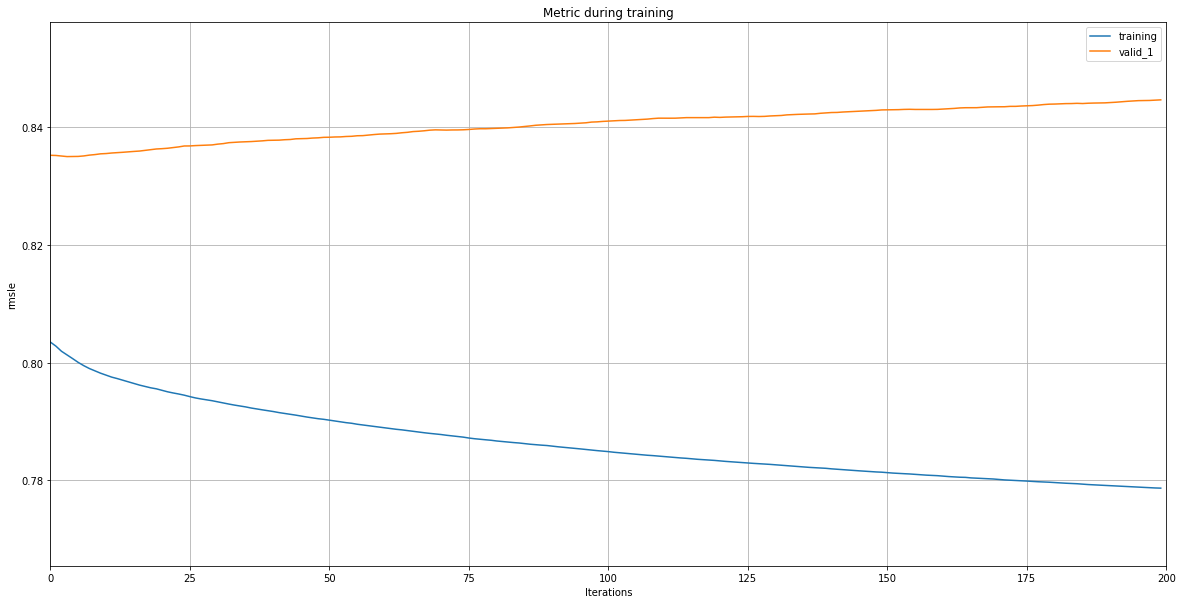

In [78]:
ax = lgb.plot_metric(evals_result, metric='rmsle')


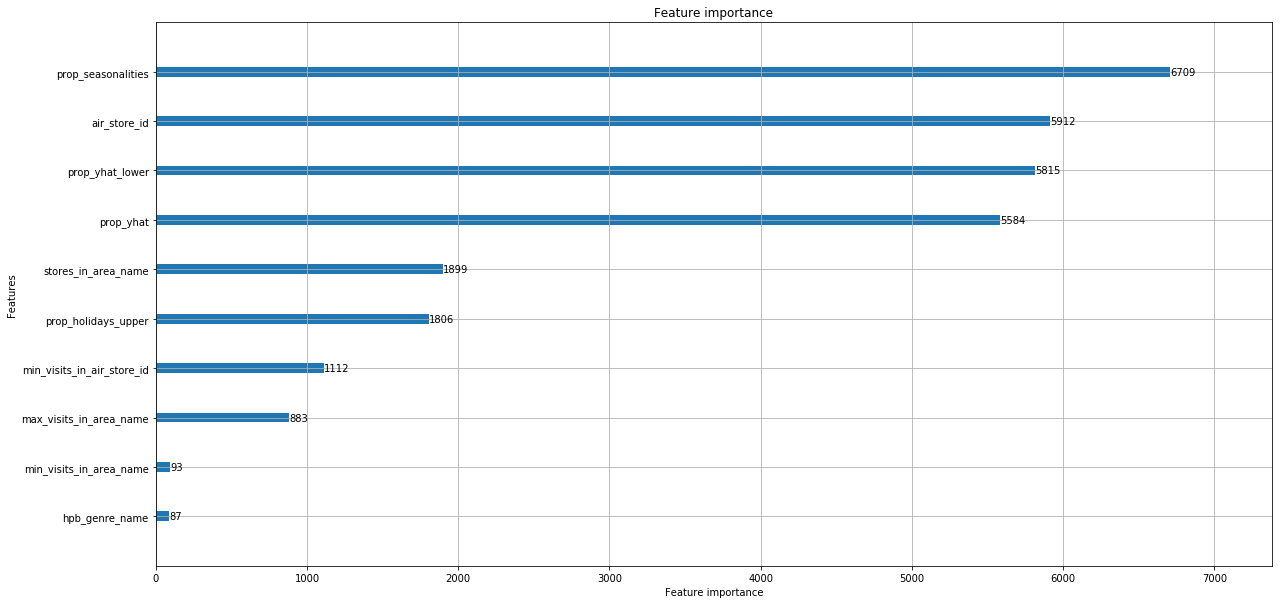

In [99]:
ax = lgb.plot_importance(gbm, max_num_features=10)


In [83]:
pred_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig)
pred_trn = gbm.predict(X_train, num_iteration=gbm.best_iteration)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig)
print('data set: {}/{} train loss: {}, valid loss: {}'.format(data_i+1, len(dat), trn_loss, valid_loss))
# rmsle(y_train_orig, tidy_data.prop_yhat.values[:226897])

data set: 1/1 train loss: 0.7786443656714005, valid loss: 0.8446894304057027


In [20]:
valid_base = 226897
public_size = int(0.14 * y_valid_orig.shape[0])

rmsle(y_valid_orig[:public_size], np.exp(tidy_data.prop_yhat.values[valid_base:valid_base + public_size]))

20.541503284085838

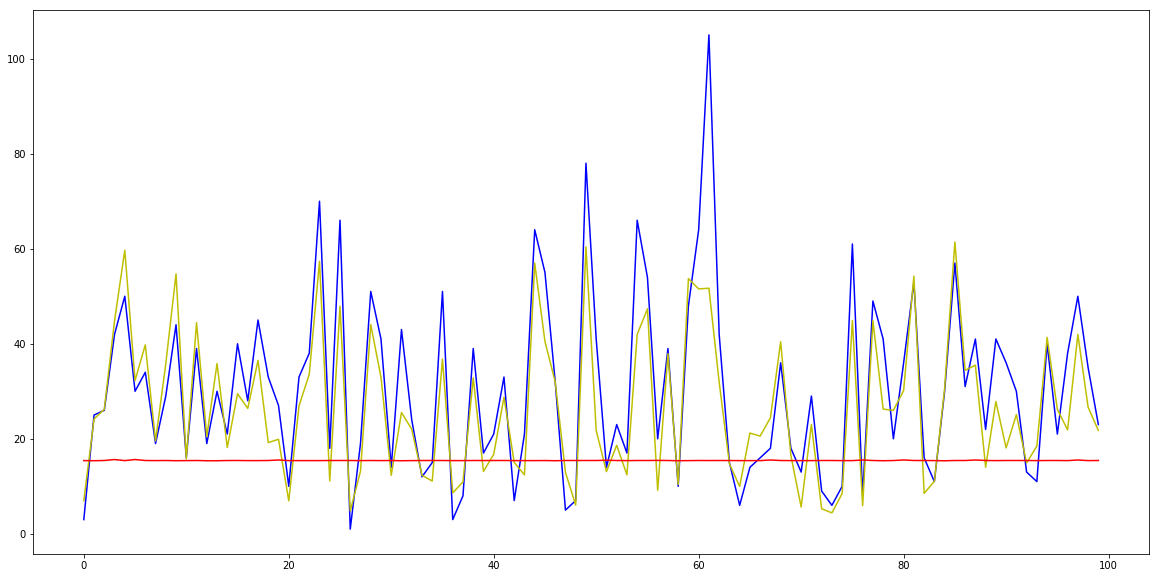

In [30]:
start = 100
step = 100
ran = slice(valid_base + start,valid_base + start + step,1)
valid_ran = slice( start, start + step,1)
plt.plot(y_valid_orig[valid_ran].values, 'b')
plt.plot(tidy_data.prop_yhat.values[ran], c='y')
plt.plot(pred_valid_orig[valid_ran], c='r')

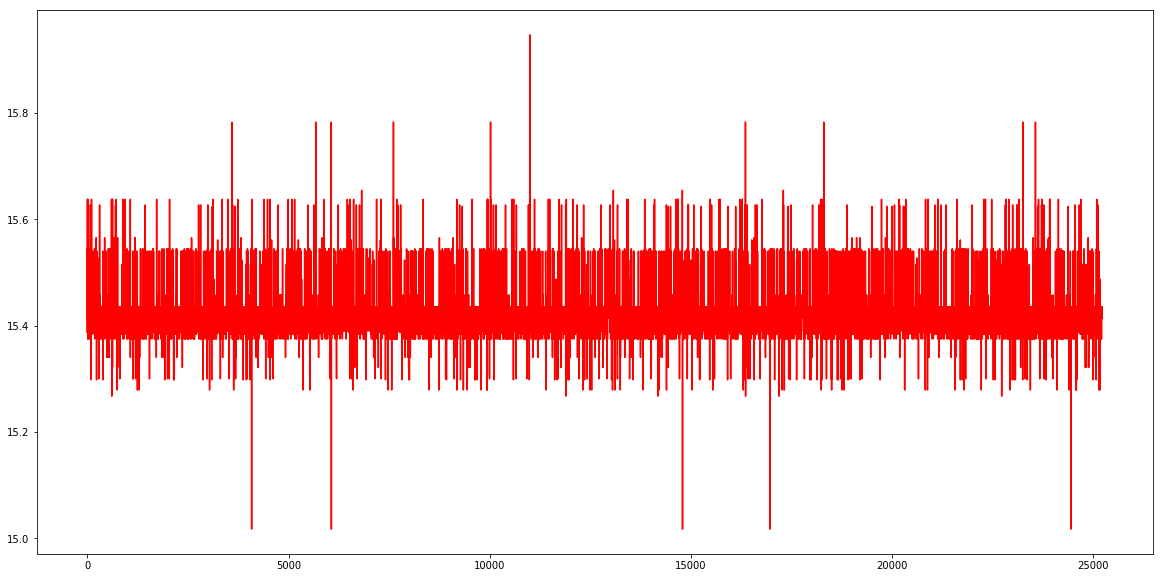

In [28]:
plt.plot(pred_valid_orig, c='r')

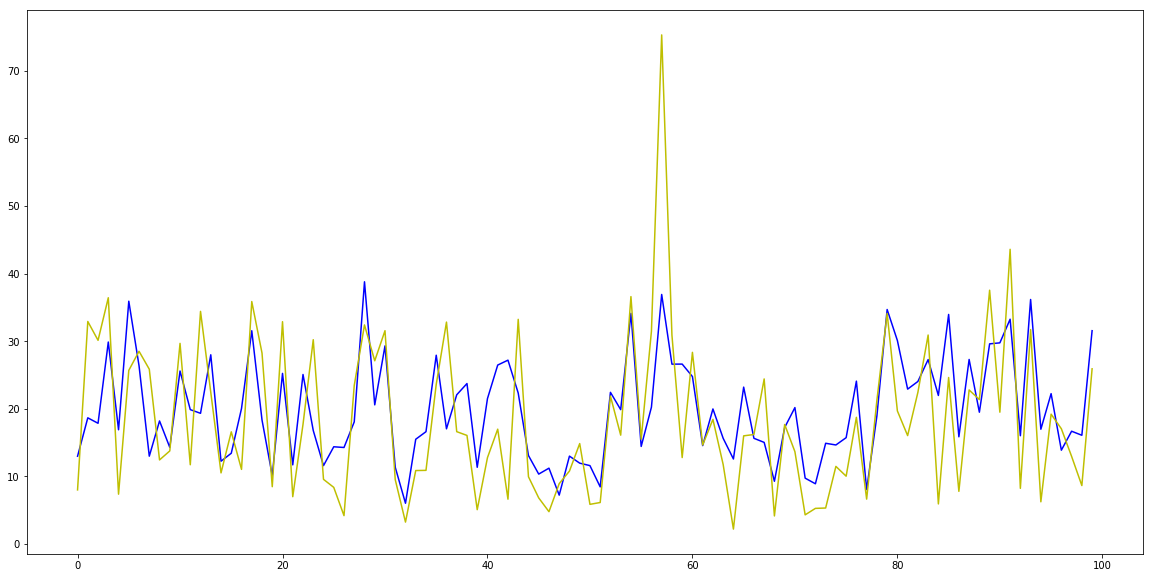

In [23]:
ran = slice(1000,1100,1)
plt.plot(pred_trn_orig[ran], 'b')
plt.plot(np.exp(tidy_data.prop_yhat.values[ran]), c='y')

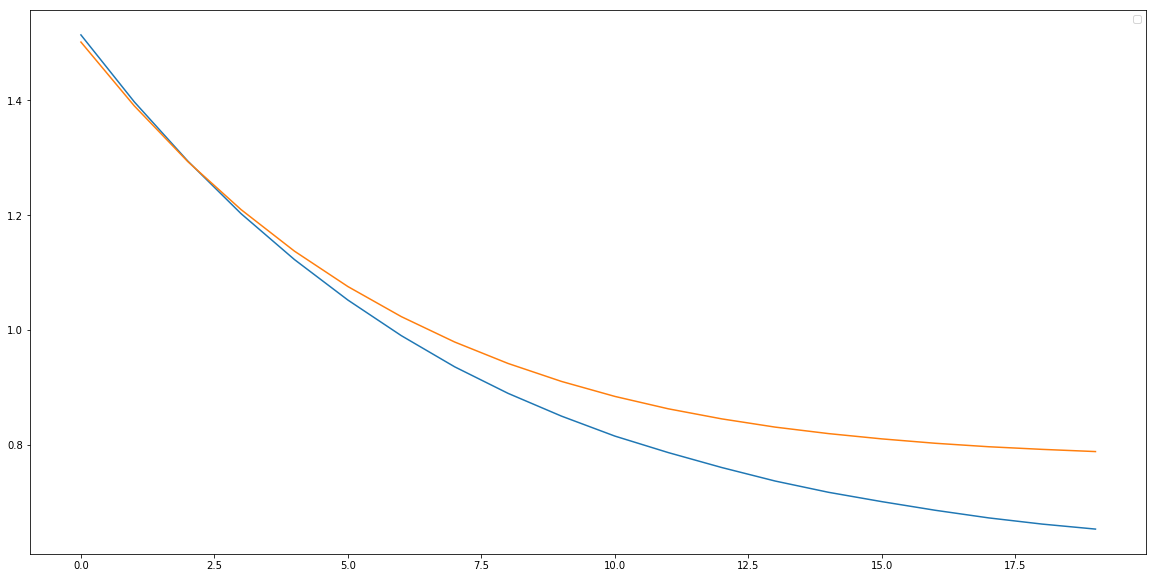

In [13]:
for key in evals_result.keys():
    plt.legend(evals_result.keys())
    plt.plot(evals_result[key]['train']['rmsle']) # blue for trn
    plt.plot(evals_result[key]['eval']['rmsle']) # red for valid

# data slice
3

4 0.7012610665198485, valid loss: 0.7356819327974975

5 0.7011597208347141, valid loss: 0.7576457536626308

6 0.7142544767975981, valid loss: 0.7377355280995211

In [ ]:
# cv_result = xgb.cv(xgb_parms, xdata, num_boost_round=40, nfold=5,
#        metrics={'error'}, seed=0, feval=rmsle_wo_log,
#        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
# cv_result

In [136]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

valid_base = 226897
X_trn = tidy_data.prop_yhat.values[:valid_base].reshape(-1, 1)

X_trn = np.log1p(X_trn) / max_log_y
Y_trn = y_train.reshape(-1, 1)
reg.fit(X_trn, Y_trn)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [156]:
valid_base = 226897
X_valid = tidy_data.prop_yhat.values[valid_base:].reshape(-1, 1)

X_valid = np.log1p(X_valid) / max_log_y
Y_valid = y_valid.values.reshape(-1, 1)

In [158]:
pred_valid = reg.predict(X_valid)

In [162]:
pred_valid = utils.log_max_inv(pred_valid, max_log_y)
Y_valid = utils.log_max_inv(Y_valid, max_log_y)
rmsle(pred_valid, Y_valid)

0.4864764820869585

In [168]:
rmsle(X_valid, np.log1p(Y_valid) / max_log_y)

0.044642335803720096

In [167]:
utils.log_max_inv(Y_valid, max_log_y)

/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:339: RuntimeWarning: overflow encountered in exp
  return np.exp(preds * mx) - 1


array([[  1.42042314e+044],
       [  2.40460833e+110],
       [  2.97200540e+040],
       ..., 
       [  7.14650892e+150],
       [  1.42042314e+044],
       [  2.49368001e+018]])

In [154]:
# X_trn_org = utils.log_max_inv(X_trn, max_log_y)
# Y_trn_org = utils.log_max_inv(Y_trn, max_log_y)

# plt.scatter(X_trn_org, Y_trn_org)
# pred = utils.log_max_inv(reg.predict(X_trn), max_log_y)
# plt.plot(X_trn_org,pred ,color='k')

# plt.plot(X_trn, diabetes_y_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

(array([  1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   5.00000000e+00,   7.00000000e+00,
          5.50000000e+01,   1.69437000e+05,   5.73820000e+04,
          7.00000000e+00]),
 array([-858.50929303, -750.80853182, -643.10777061, -535.4070094 ,
        -427.70624818, -320.00548697, -212.30472576, -104.60396455,
           3.09679667,  110.79755788,  218.49831909]),
 <a list of 10 Patch objects>)

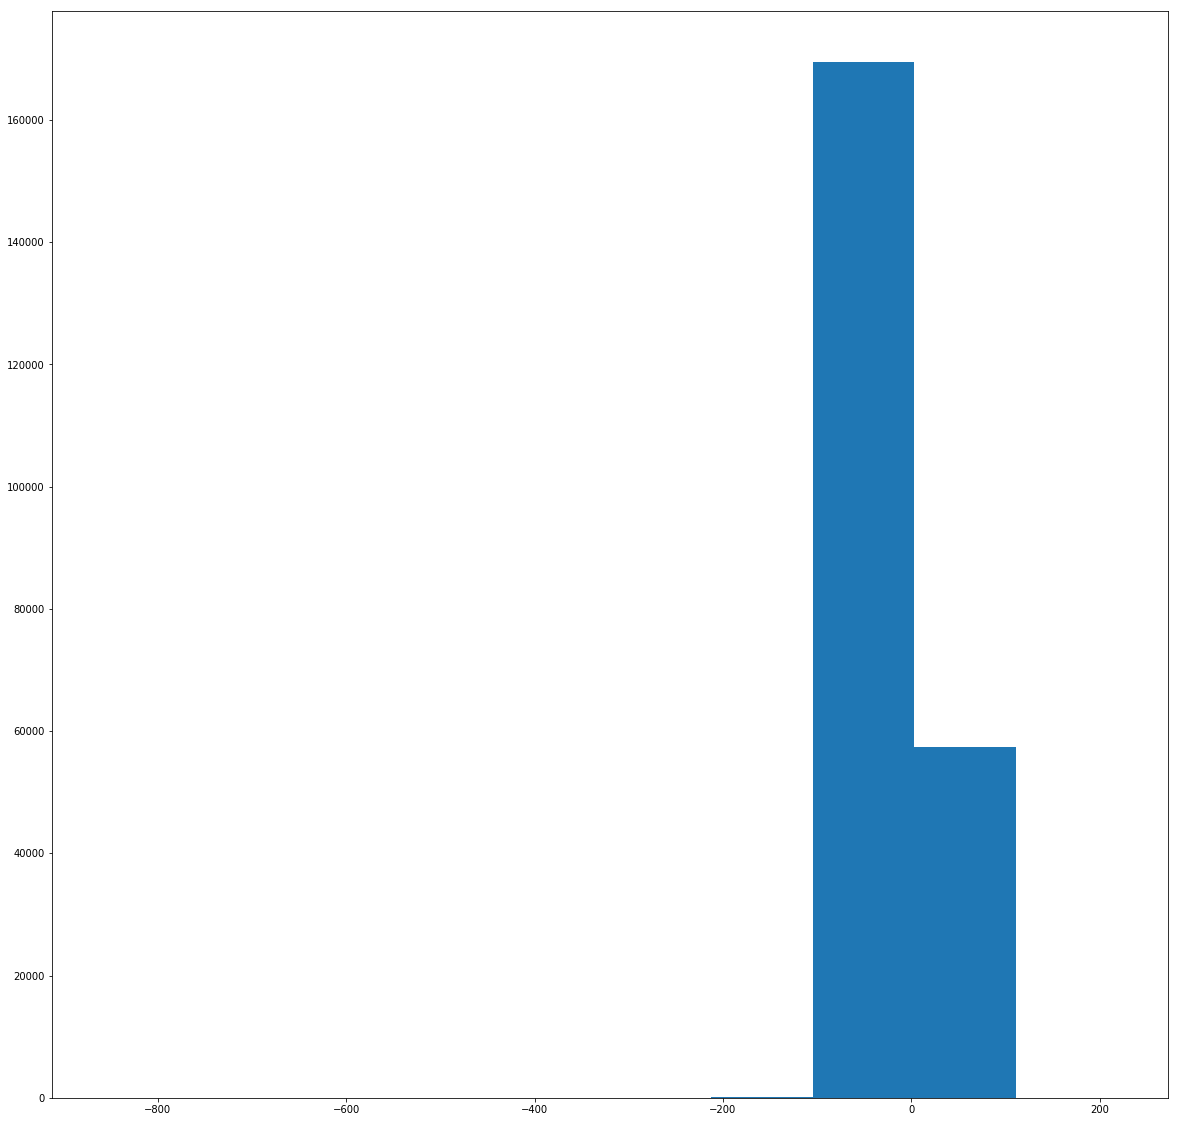

In [155]:
plt.hist(X_trn_org - Y_trn_org)

In [135]:
X_trn

array([[ 12.58478283],
       [ 55.83542927],
       [ 77.03928234],
       ..., 
       [ 11.20383249],
       [ 34.3765406 ],
       [ 40.86023258]])